In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/omdena_ad

/content/drive/MyDrive/omdena_ad


In [3]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [4]:
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import random
import os
from scipy.ndimage import rotate
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Dropout
from keras import backend as K
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from keras.utils import to_categorical
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization
from imblearn.over_sampling import SMOTE

<ipython-input-4-af78137fdb6e>:27: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

100% 34.0M/34.1M [00:01<00:00, 39.8MB/s]
100% 34.1M/34.1M [00:01<00:00, 25.1MB/s]


In [ ]:
! mkdir omdena_kaggle
!ls
!unzip alzheimers-dataset-4-class-of-images.zip -d omdena_kaggle

Streaming output truncated to the last 5000 lines.
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: omdena_kaggle/Alzheimer_

In [5]:
train_data_dir = "/content/drive/MyDrive/omdena_ad/omdena_kaggle/Alzheimer_s Dataset/train/"
test_data_dir = "/content/drive/MyDrive/omdena_ad/omdena_kaggle/Alzheimer_s Dataset/test/"
all_dataset_dir =  "/content/drive/MyDrive/omdena_ad/omdena_kaggle/Alzheimer_s Dataset/all_dataset"

In [ ]:
# combine train and test dataset to a single folder to split them later into train, test and val
# copy_tree(train_data_dir, all_dataset_dir)
# copy_tree(test_data_dir, all_dataset_dir)
# print(os.listdir(all_dataset_dir))

In [6]:
data_class = sorted(os.listdir(all_dataset_dir))

In [7]:
for dir in data_class:
    if dir == 'MildDemented':
      dir_path_mild_dem = os.path.join(all_dataset_dir, dir)
      mild_demented = os.listdir(dir_path_mild_dem)

    elif dir == 'ModerateDemented':
      dir_path_mod_dem = os.path.join(all_dataset_dir, dir)
      moderate_demented = os.listdir(dir_path_mod_dem)

    elif dir == 'NonDemented':
      dir_path_non_dem = os.path.join(all_dataset_dir, dir)
      non_demented = os.listdir(dir_path_non_dem)

    elif dir == 'VeryMildDemented':
      dir_path_v_m_dem = os.path.join(all_dataset_dir, dir)
      very_mild_demented = os.listdir(dir_path_v_m_dem)

In [8]:
len(os.listdir(dir_path_mild_dem))

896

In [9]:
 len(os.listdir(dir_path_mod_dem))

64

In [10]:
len(os.listdir(dir_path_non_dem))

3200

In [11]:
len(os.listdir(dir_path_v_m_dem))

2240

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255
    #validation_split=0.2
)
batch_size = 6500

# Create a flow generator for training data
train_generator = train_datagen.flow_from_directory(
    all_dataset_dir,             # Path to the training data directory
    target_size=(176, 176), # Target size of the images (height, width)
    batch_size=batch_size,  # Size of the batches
    class_mode='categorical' # Type of labels (binary or categorical)
    #subset = 'training'
)

Found 6400 images belonging to 4 classes.


In [13]:
train_data, train_labels = train_generator.next()

In [14]:
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [15]:
train_data, val_data, train_labels, val_labels = sklearn.model_selection.train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [16]:
# image number for [mild, mod, non, very_mild] before SMOTE
train_image_num_before_smote = np.sum(train_labels, axis=0)
test_image_num_before_smote = np.sum(test_labels, axis=0)
val_image_num_before_smote = np.sum(val_labels, axis=0)
print(train_image_num_before_smote, test_image_num_before_smote, val_image_num_before_smote)


[ 579.   46. 2035. 1436.] [162.  10. 650. 458.] [155.   8. 515. 346.]


In [17]:
print(train_data.shape, train_labels.shape, val_data.shape, val_labels.shape)

(4096, 176, 176, 3) (4096, 4) (1024, 176, 176, 3) (1024, 4)


In [ ]:
# #SMOTE to tackle class imbalance, but only to training data
# sm = SMOTE(random_state=42)
# train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
# train_data = train_data.reshape(-1, 176, 176, 3)
# print(train_data.shape, train_labels.shape)

In [18]:
# image number for [mild, mod, non, very_mild] after SMOTE
train_image_num_after_smote = np.sum(train_labels, axis=0)
test_image_num_after_smote = np.sum(test_labels, axis=0)
val_image_num_after_smote = np.sum(val_labels, axis=0)
print(train_image_num_after_smote, test_image_num_after_smote, val_image_num_after_smote)


[ 579.   46. 2035. 1436.] [162.  10. 650. 458.] [155.   8. 515. 346.]


In [19]:
# Defining the model

num_conv_layers = 2
conv_0_filters = 64
conv_0_kernel = 3
num_dense_layers = 3
dense_0_units = 256
dense_1_units = 224
dense_2_units = 64
learning_rate = 0.00023557488496216865
conv_1_filters = 16
conv_1_kernel = 5

# Define the model
model = Sequential()

# Add convolutional layers
for i in range(num_conv_layers):
    model.add(Conv2D(
        filters=eval(f'conv_{i}_filters'),
        kernel_size=eval(f'conv_{i}_kernel'),
        activation='relu',
        padding='same',
        input_shape=(176, 176, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if i == 0:
      model.add(BatchNormalization())
      model.add(Dropout(0.4))  # Adding dropout for regularization
    elif i == 1:
      #model.add(BatchNormalization())
      model.add(Dropout(0.2))  # Adding dropout for regularization

model.add(Flatten())

# Add dense layers
for i in range(num_dense_layers):
    model.add(Dense(
        units=eval(f'dense_{i}_units'),
        activation='relu'
    ))
    if i == 0:
      model.add(BatchNormalization())
      #model.add(Dropout(0.5))  # Adding dropout for regularization
    elif i == 1:
      #model.add(BatchNormalization())
      model.add(Dropout(0.3))  # Adding dropout for regularization
    elif i == 2:
      model.add(BatchNormalization())
      model.add(Dropout(0.1))  # Adding dropout for regularization


# Output layer
model.add(Dense(4, activation='softmax'))

# Choose the learning rate
opt = tensorflow.keras.optimizers.Adam(learning_rate)
# Compile the model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 88, 88, 64)        256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 88, 88, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 16)        25616     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 16)        0

In [20]:
# Save the model to an h5 file
model.save('model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
model_checkpoint = ModelCheckpoint('best_model_custom_1.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', verbose=1, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, mode='min', verbose=1)
callbacks_list = [model_checkpoint] #, reduce_lr]

In [22]:
history = model.fit(train_data, train_labels, epochs=100, validation_data=(val_data, val_labels), batch_size=16, callbacks=callbacks_list)

Epoch 1/100
255/256 [============================>.] - ETA: 0s - loss: 1.4124 - accuracy: 0.4353
Epoch 1: val_accuracy improved from -inf to 0.33789, saving model to best_model_custom_1.h5
256/256 [==============================] - 19s 44ms/step - loss: 1.4106 - accuracy: 0.4353 - val_loss: 2.8650 - val_accuracy: 0.3379
Epoch 2/100
255/256 [============================>.] - ETA: 0s - loss: 0.9762 - accuracy: 0.6230
Epoch 2: val_accuracy improved from 0.33789 to 0.41699, saving model to best_model_custom_1.h5
256/256 [==============================] - 10s 40ms/step - loss: 0.9764 - accuracy: 0.6230 - val_loss: 1.4835 - val_accuracy: 0.4170
Epoch 3/100
255/256 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.7527
Epoch 3: val_accuracy improved from 0.41699 to 0.67676, saving model to best_model_custom_1.h5
256/256 [==============================] - 12s 46ms/step - loss: 0.6614 - accuracy: 0.7524 - val_loss: 0.8099 - val_accuracy: 0.6768
Epoch 4/100
255/256 [=======

In [23]:
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/omdena_ad/model_1.h5')
model.load_weights('/content/drive/MyDrive/omdena_ad/best_model_custom_1.h5')

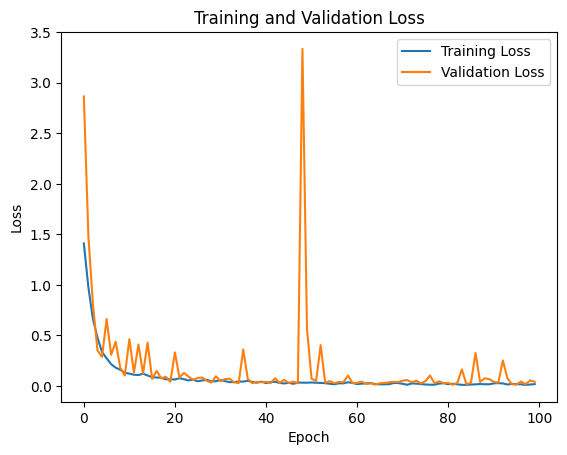

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

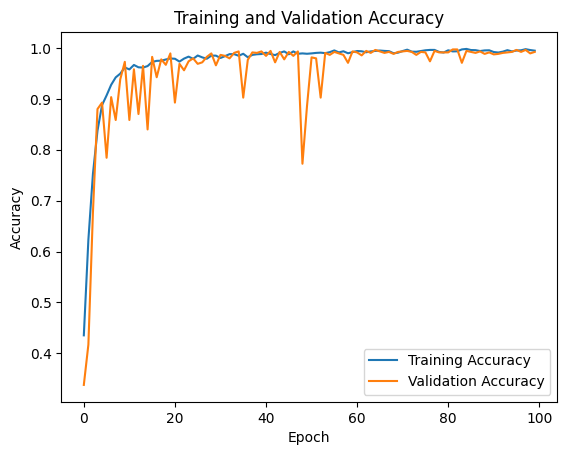

In [25]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**PREDICTION ON THE VALIDATION DATA**

In [26]:
pred_val = model.predict(val_data)

32/32 [==============================] - 1s 11ms/step


<Axes: >

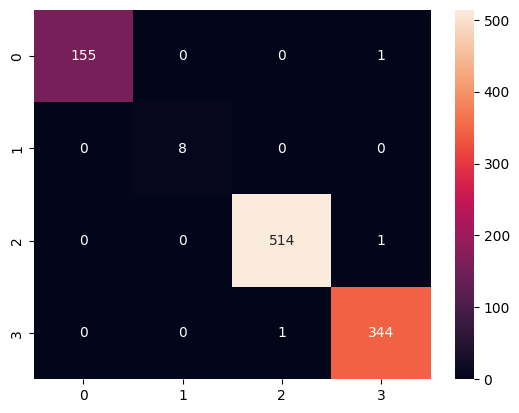

In [27]:
predict_val = np.argmax(pred_val, axis=1)
true_val = np.argmax(val_labels, axis=1)
cm = confusion_matrix(predict_val, true_val)
sns.heatmap(cm, annot=True, fmt='d')

In [28]:
val_report = classification_report(true_val, predict_val)
print(val_report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       155
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00       515
           3       1.00      0.99      1.00       346

    accuracy                           1.00      1024
   macro avg       1.00      1.00      1.00      1024
weighted avg       1.00      1.00      1.00      1024



**PREDICTION ON THE TEST DATA**

In [29]:
test_scores = model.evaluate(test_data, test_labels)

40/40 [==============================] - 1s 14ms/step - loss: 0.0227 - accuracy: 0.9922


In [30]:
pred_test = model.predict(test_data)

40/40 [==============================] - 0s 12ms/step


<Axes: >

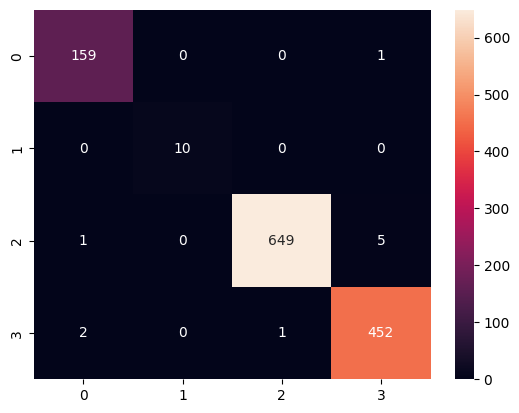

In [31]:
predict_test = np.argmax(pred_test, axis=1)
true_test = np.argmax(test_labels, axis=1)
cm = confusion_matrix(predict_test, true_test)
sns.heatmap(cm, annot=True, fmt='d')

In [32]:
test_report = classification_report(true_test, predict_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       162
           1       1.00      1.00      1.00        10
           2       0.99      1.00      0.99       650
           3       0.99      0.99      0.99       458

    accuracy                           0.99      1280
   macro avg       0.99      0.99      0.99      1280
weighted avg       0.99      0.99      0.99      1280

